<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Time Series Analysis</h1>
        <h1>Fourier Analysis</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import datetime

import numpy as np
import pandas as pd

import scipy as sp
import scipy.fftpack

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import watermark

%matplotlib inline
%load_ext watermark

List out the versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: f9d4cec09ba53403d784a160040012e6b7630793

matplotlib: 3.3.2
json      : 2.0.9
pandas    : 1.1.3
scipy     : 1.6.1
watermark : 2.1.0
numpy     : 1.19.2



Set the default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Generate some fake data

In [4]:
t_max = 4 # signal duration (seconds)
sample_freq = 250 # points per second
N = t_max*sample_freq
t = np.linspace(0, t_max, N)
amp = np.array([1, .3, .1])
freq = np.array([1, 2, 10])

Plot the individual components and the total signal

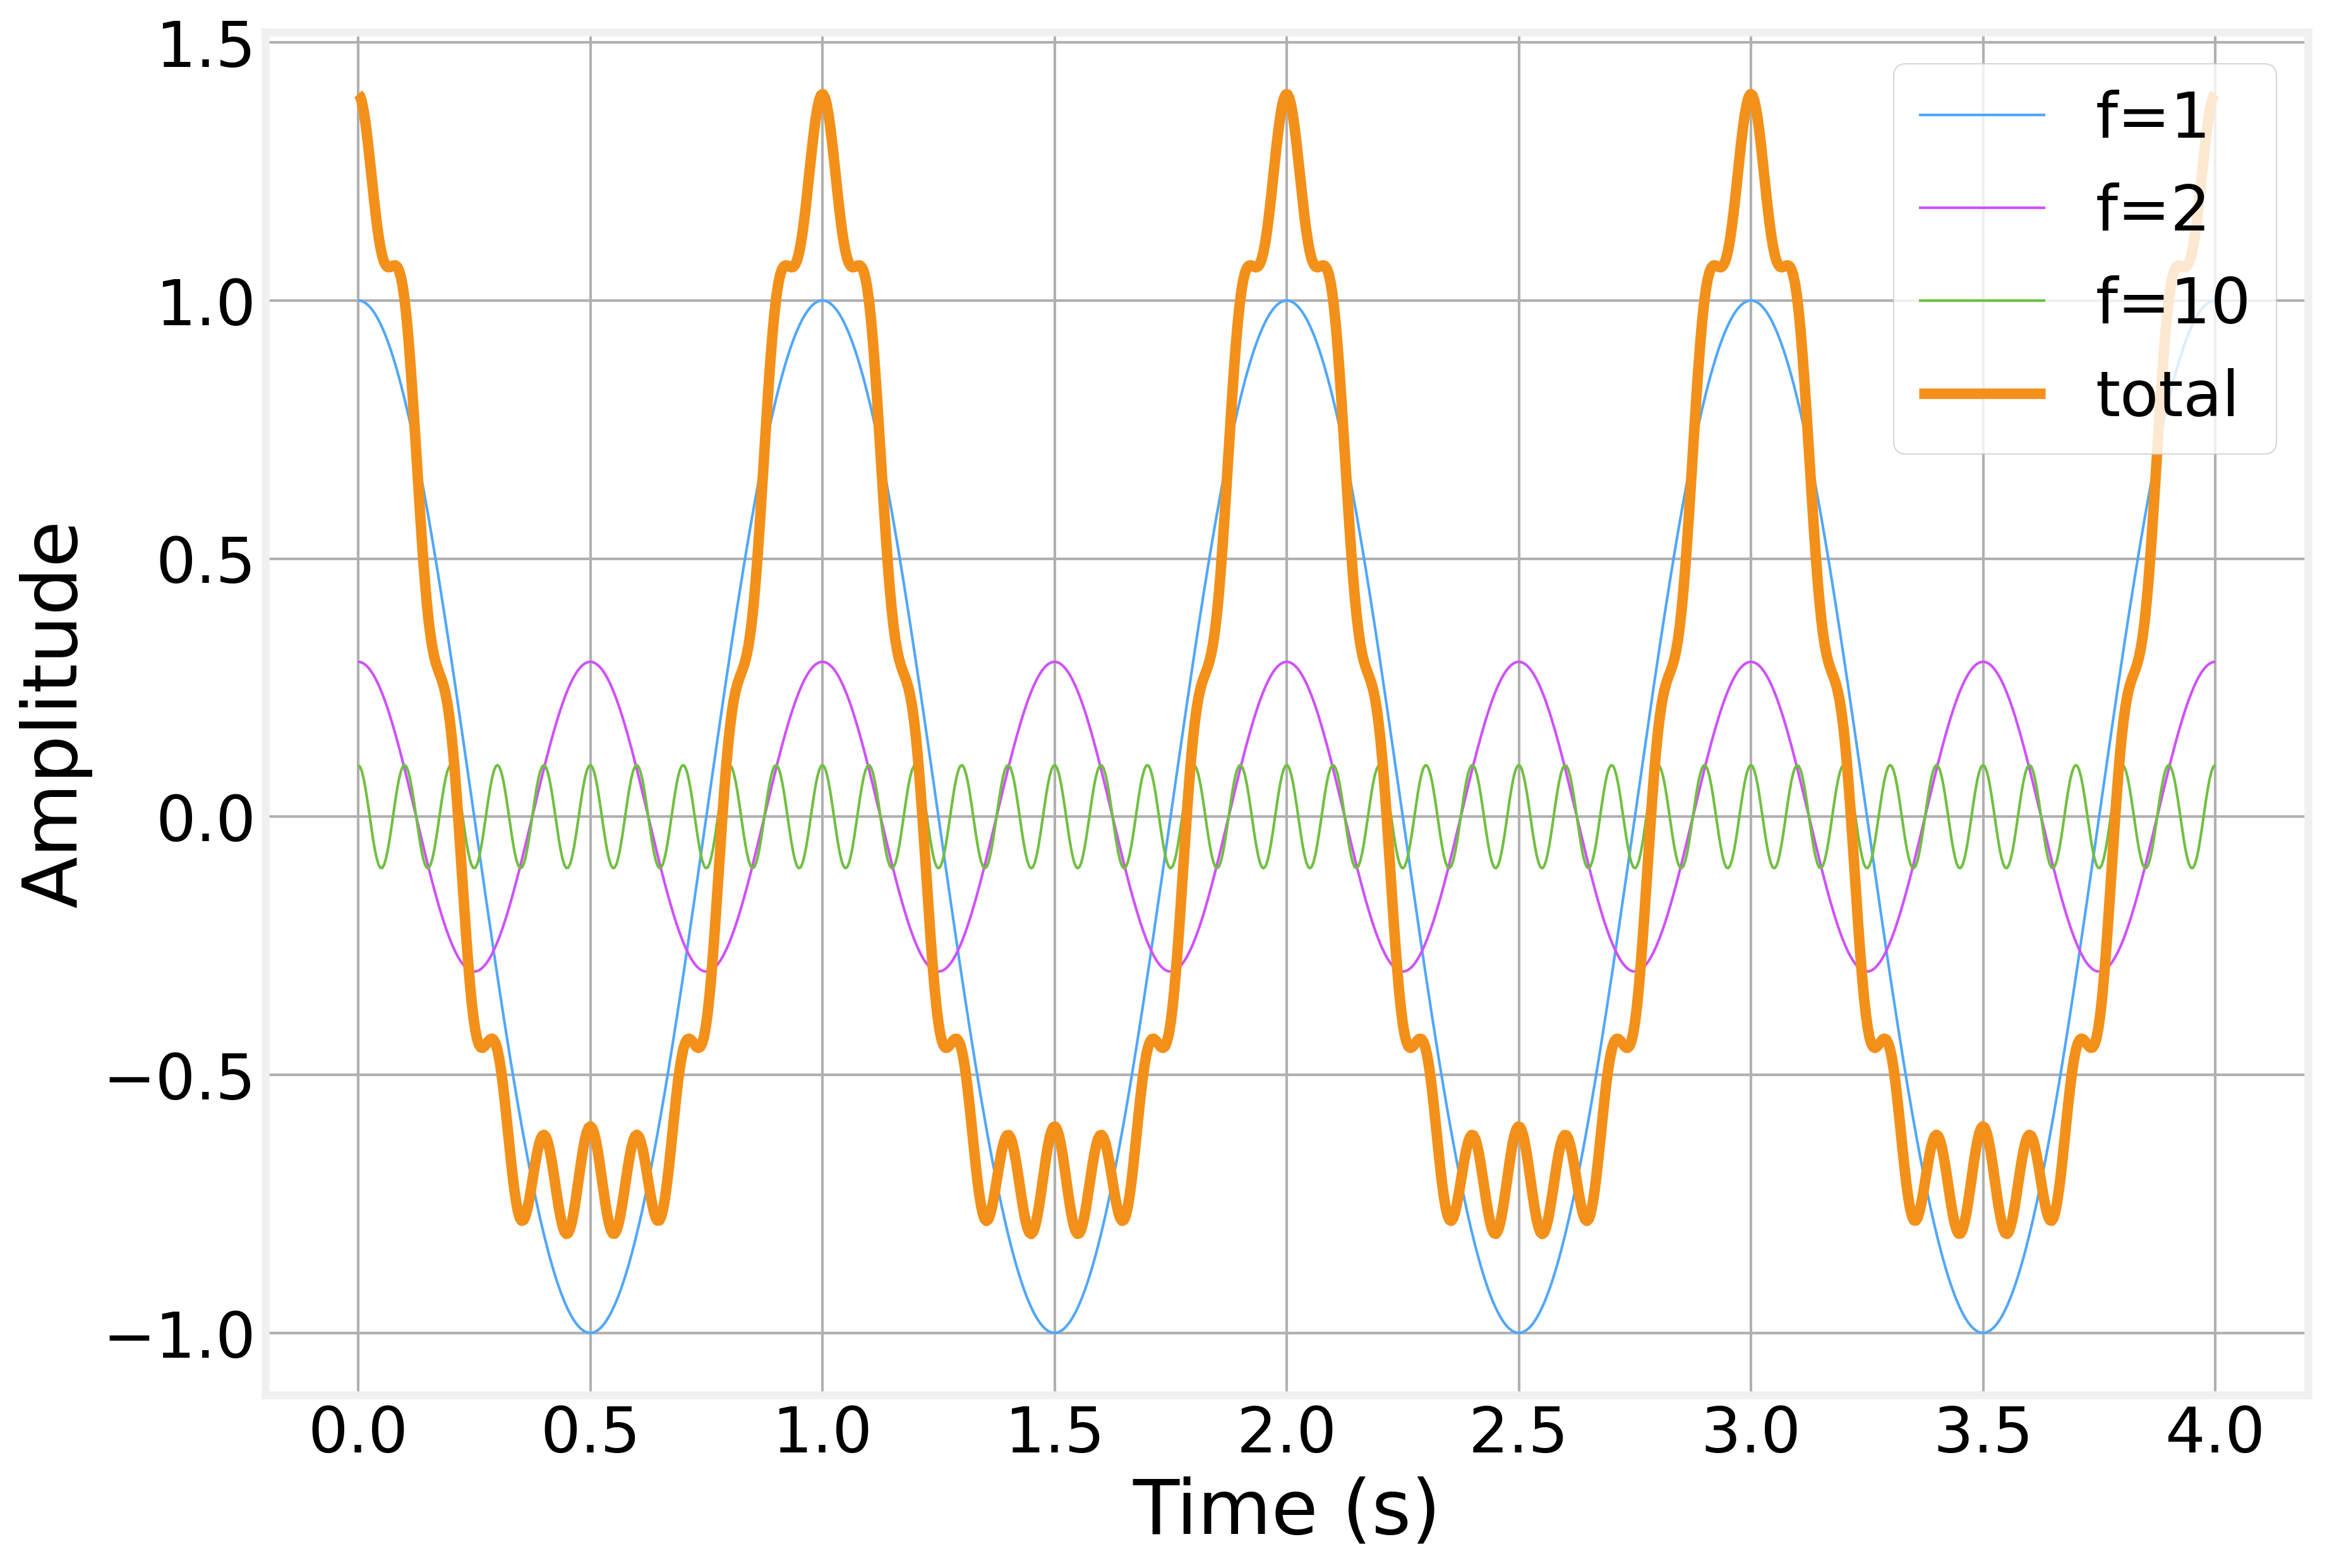

In [5]:
total = np.zeros(N)
components = []

n_freq = len(freq)

for i in range(n_freq):
    current = amp[i]*np.cos(2*np.pi*freq[i]*t)
    total += current
    
    components.append(current)
    plt.plot(t, current, label='f='+str(freq[i]), lw=1)

    
plt.plot(t, total, label='total')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

Get the color cycle

In [6]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Vizualize in 3D

(0.0, 12.0)

/Users/bgoncalves/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


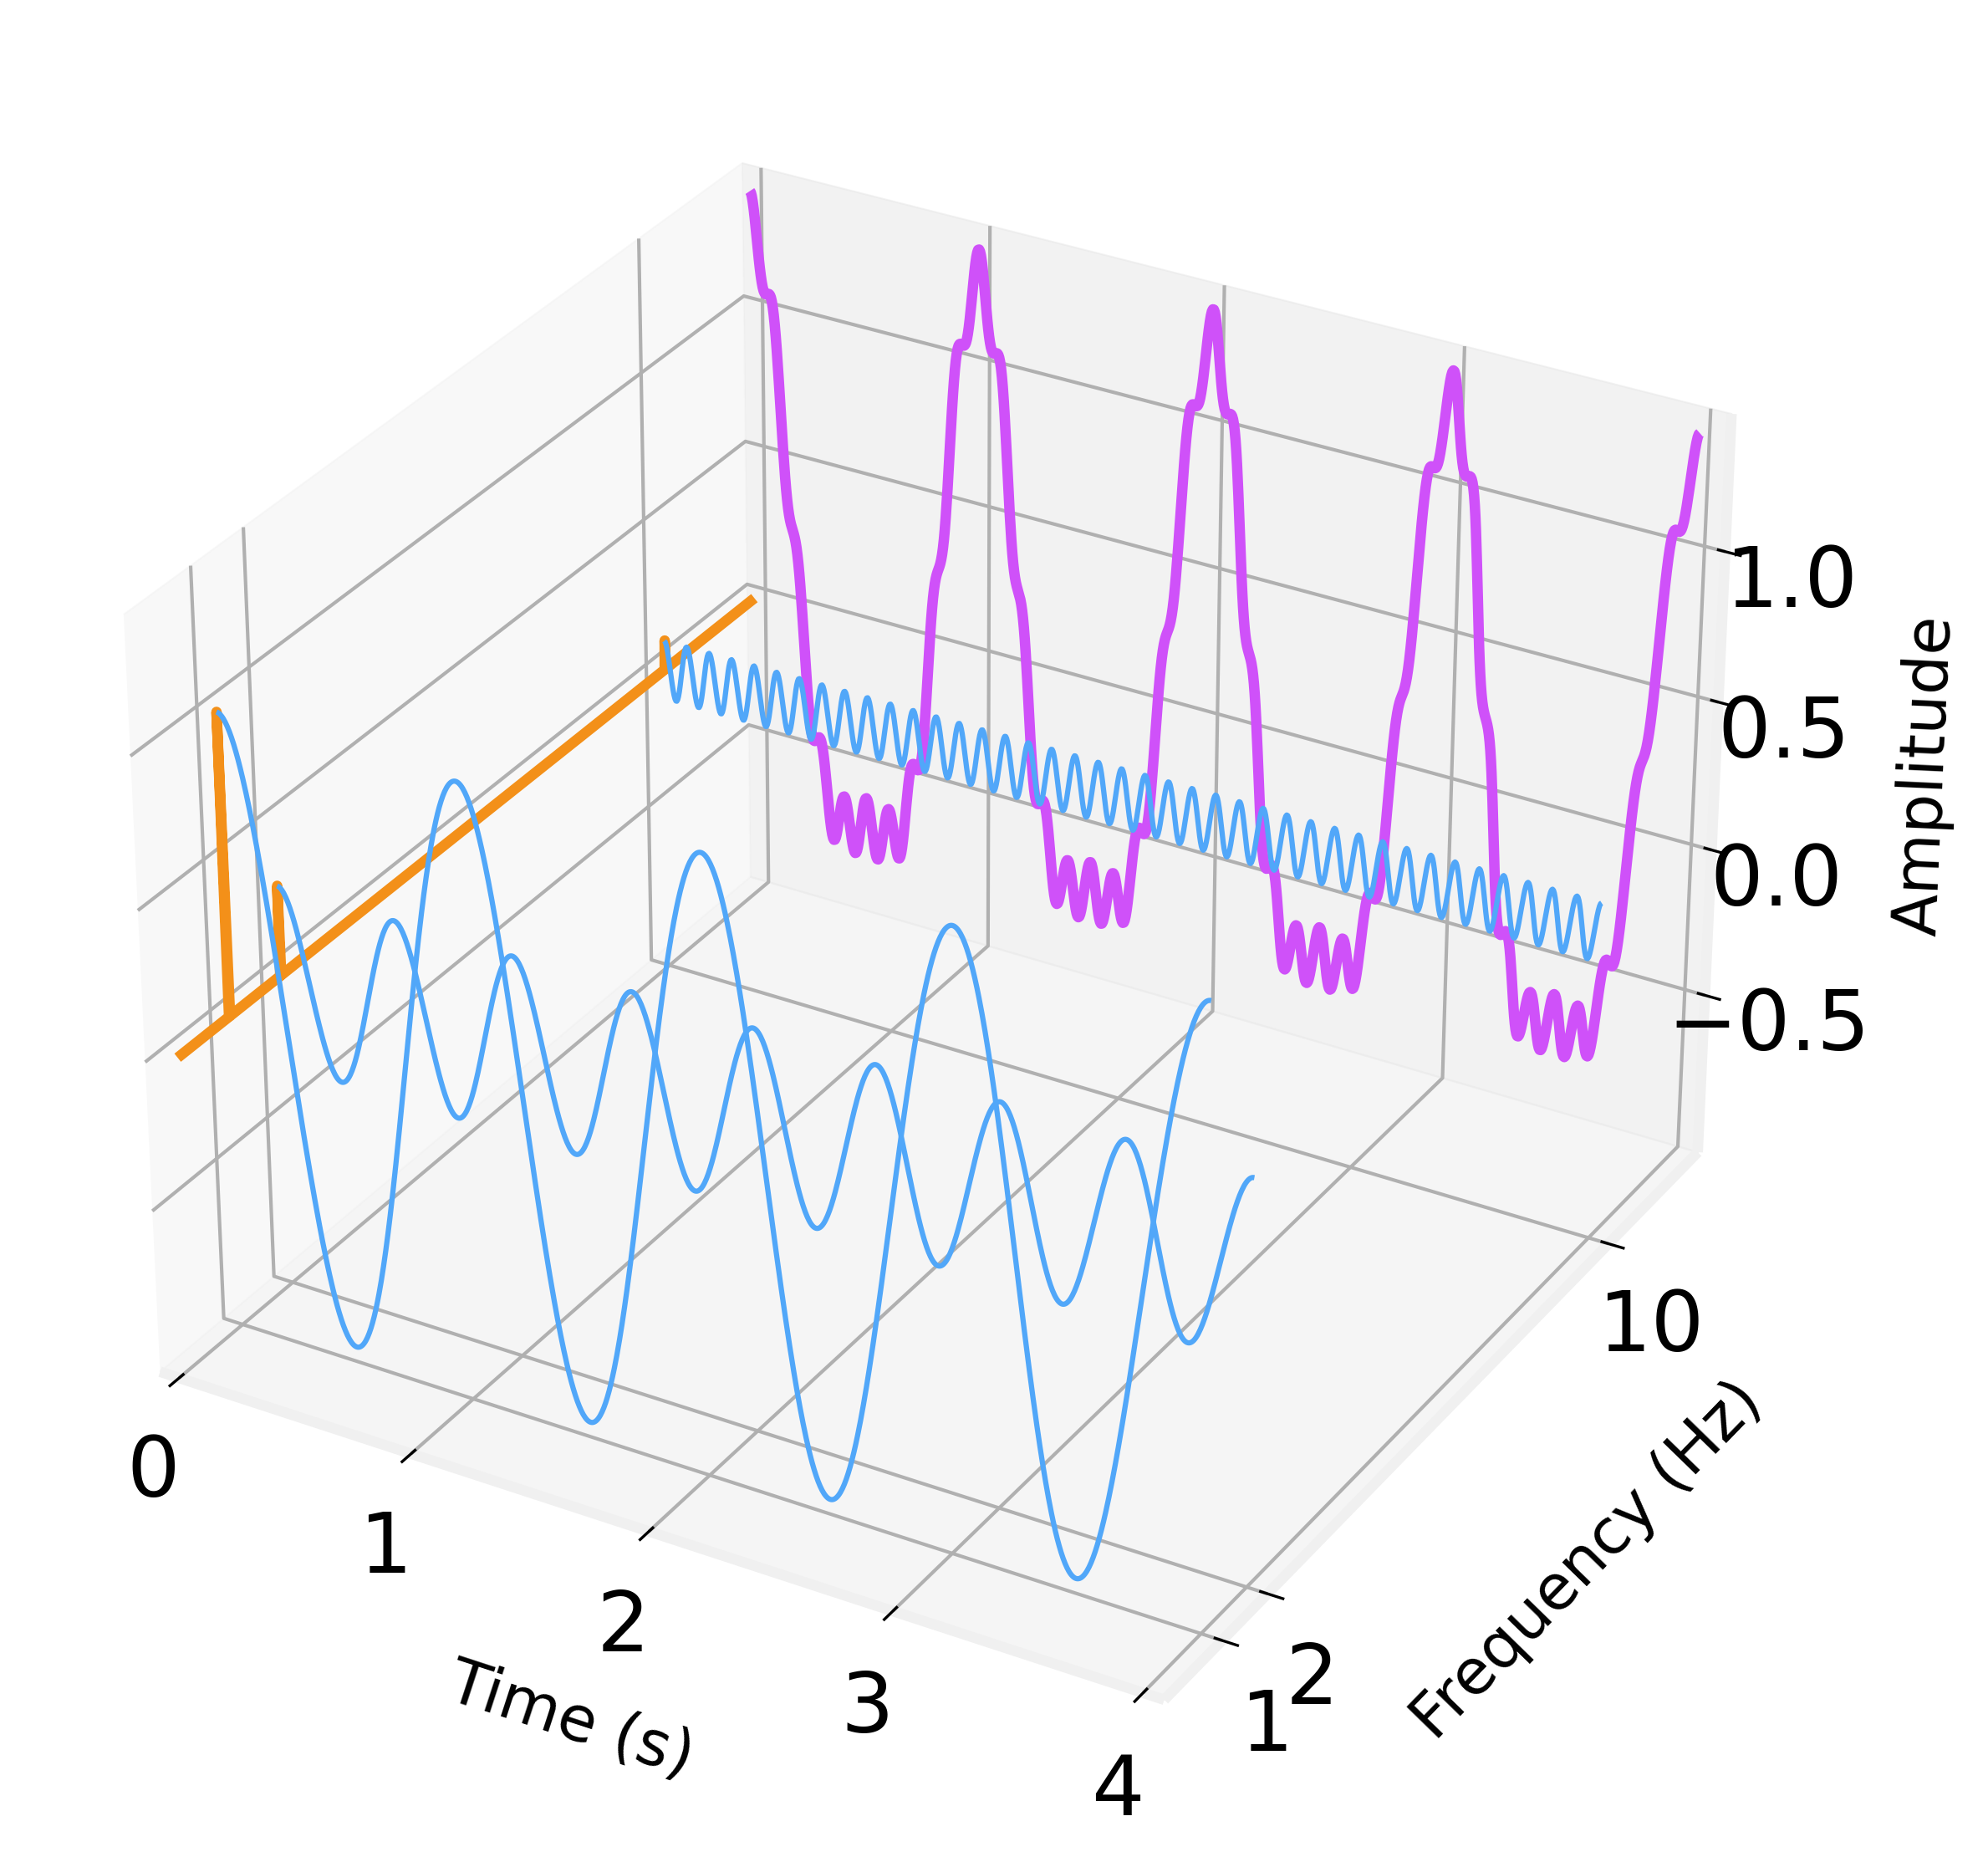

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("\n\nTime (s)", fontsize=18)
ax.set_ylabel("\n\nFrequency (Hz)", fontsize=18)
ax.set_zlabel("\n\nAmplitude", fontsize=18)

linewidth = 1

n_freq = np.max(freq)+2
x = np.linspace(0,4,1000)
y = np.ones(x.size)

# Plot the total signal
ax.plot(x, y*n_freq, total, linewidth=3, color=colors[1])

# Plot the amplitudes
z = np.zeros(n_freq*100)
z[freq*100] = amp

ax.plot(np.zeros(n_freq*100), np.linspace(0, n_freq, n_freq*100), z, 
        linewidth=3, color=colors[3])

# Plot the components
y = np.ones(1000)
for i in range(0, len(components)):
    ax.plot(x, y*freq[i], components[i], linewidth=1.5, color=colors[0])
    
ax.set_yticks(freq)
ax.set_yticklabels(freq)

ax.set_xlim(0, t_max)
ax.set_ylim(0, n_freq)

We can also recover the original frequencies and amplitudes from the total signal, by taking the fourier transform

In [8]:
fft_values = scipy.fftpack.fft(total)

The result is an array of complex numbers

In [9]:
fft_values.dtype

dtype('complex128')

To recover the real component of the signal, we simply take the absolute value. The imaginary components corresponds to phase information

In [10]:
fft_real = 2.0/N * np.abs(fft_values[0:N//2])

We see that only a few values are significantly different from zero:

In [11]:
np.where(fft_real>0.01)

(array([ 4,  8, 40]),)

To properly recover the corresponding freqency values, we must calculate the freqency resolution

In [12]:
freq_resolution = sample_freq/N

This is the value we need to convert indices into frequencies

In [13]:
freq_values = np.arange(N)*freq_resolution

So now we can plot the recovered amplitudes with the matching frequencies. For clarity, we plot only the first 50 values and the compare with the original input values

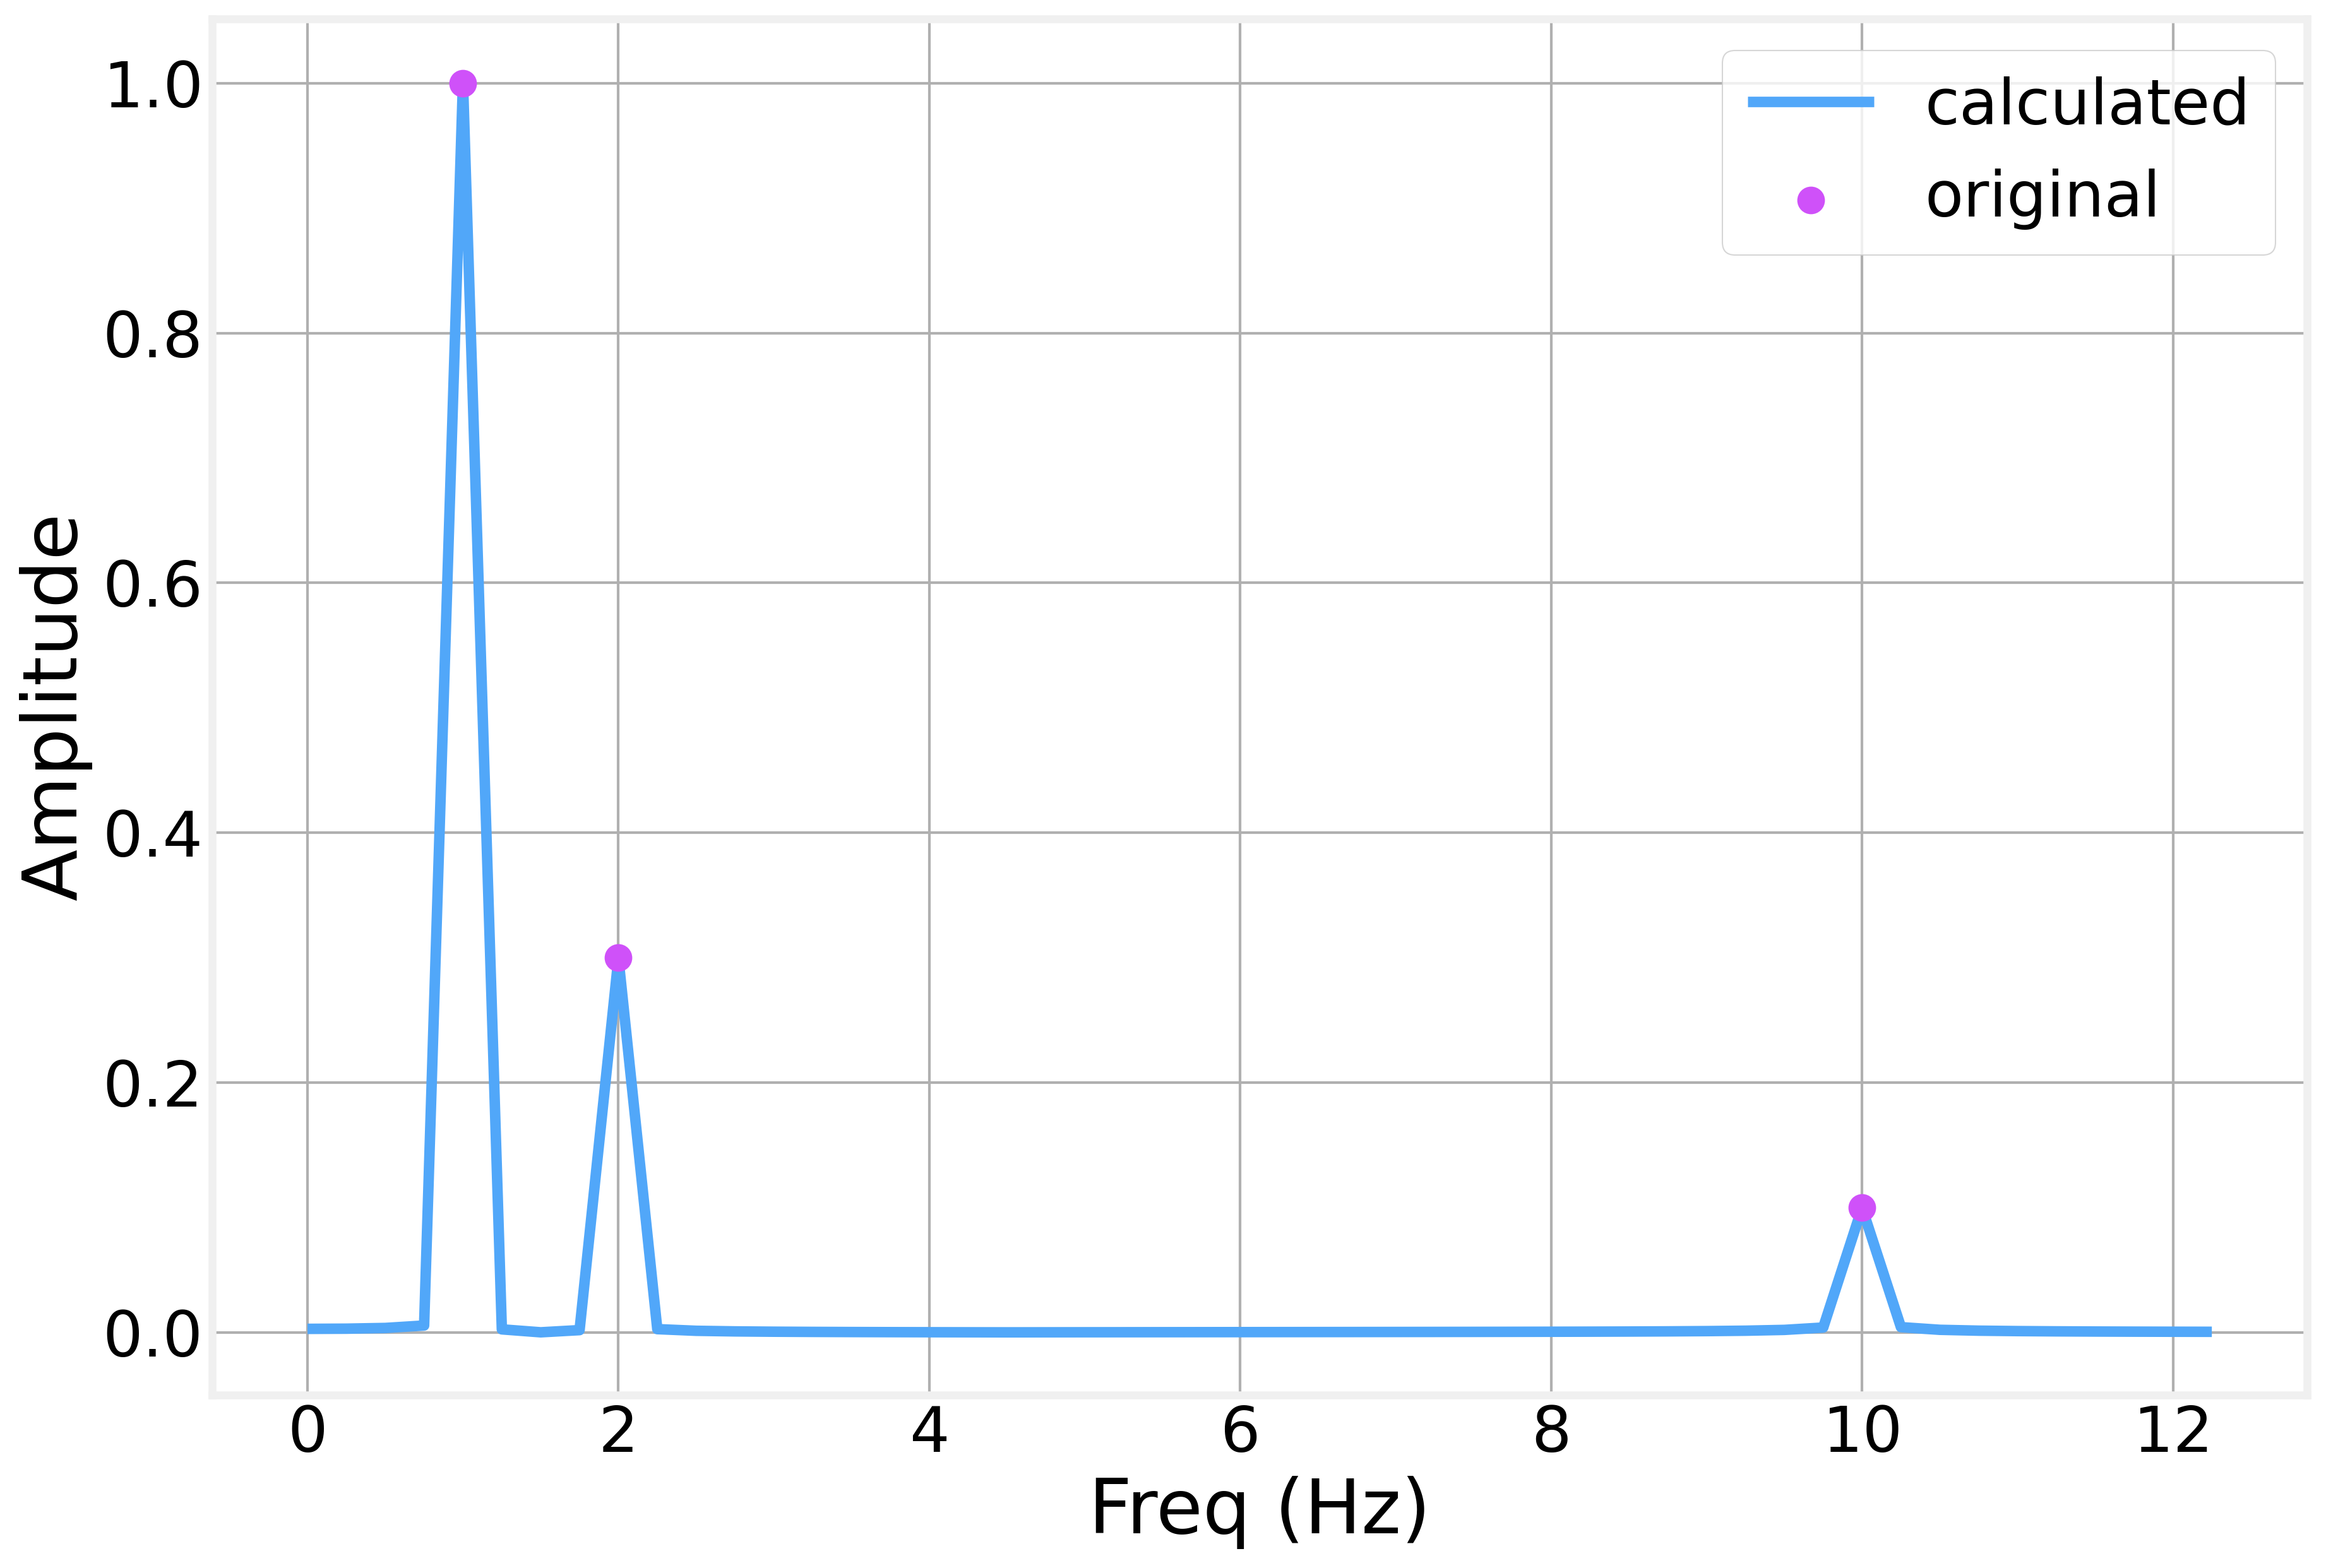

In [14]:
plt.plot(freq_values[:50], fft_real[:50], label='calculated')
plt.scatter(freq, amp, s=100, color=colors[1], zorder=3, label='original')
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude')
plt.legend()

## Load ILI dataset

In [15]:
ILI = pd.read_csv('data/CDC.csv')
ILI['date'] = ILI['Year']+ILI['Week']/52.

Visualize it

Text(0, 0.5, '% Mortality')

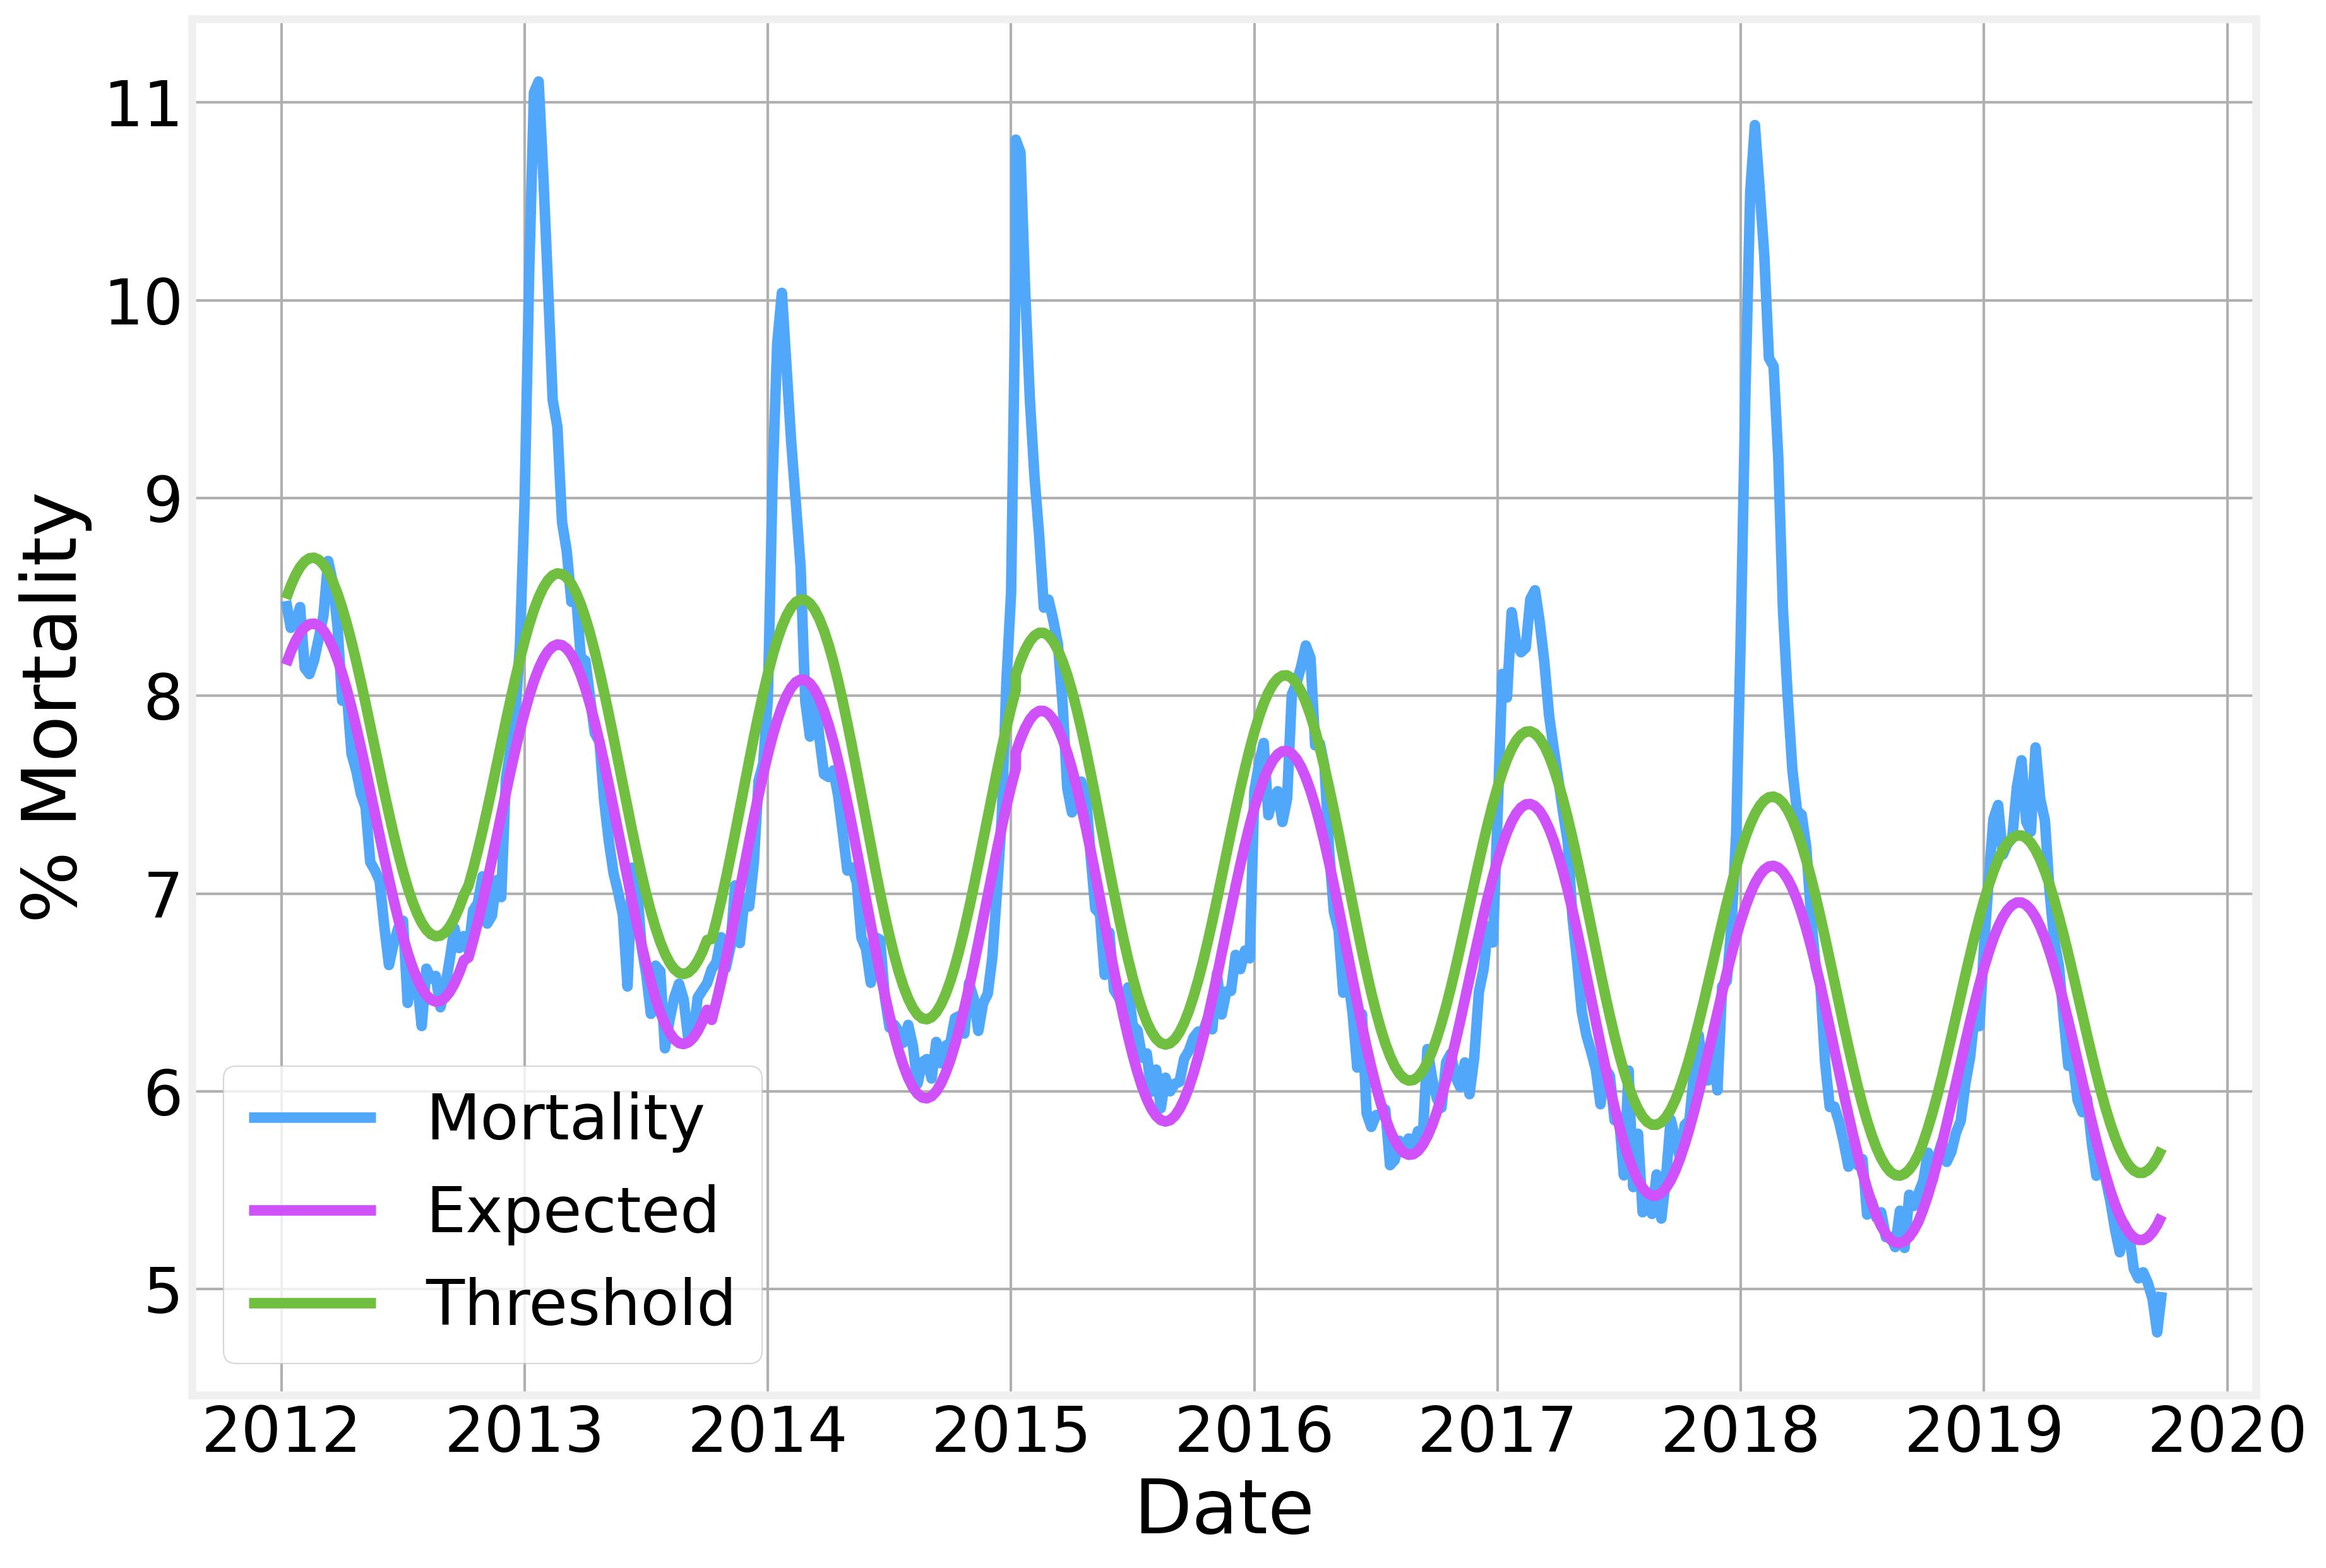

In [16]:
ILI.plot(x='date', y=['Percent of Deaths Due to Pneumonia and Influenza', 'Expected', 'Threshold'])
ax = plt.gca()
ax.legend(['Mortality', 'Expected', 'Threshold'])
ax.set_xlabel('Date')
ax.set_ylabel('% Mortality')

Calculate the FFT

In [17]:
signal = ILI['Percent of Deaths Due to Pneumonia and Influenza']
date = ILI['date']
N = len(signal)
fft_values = scipy.fftpack.fft(signal.values)

And the frequencies

In [18]:
freq_values = scipy.fftpack.fftfreq(N, 1/52) # 52 weeks per year

Plot the amplitude as a function of frequency 

Text(0, 0.5, 'Amplitude')

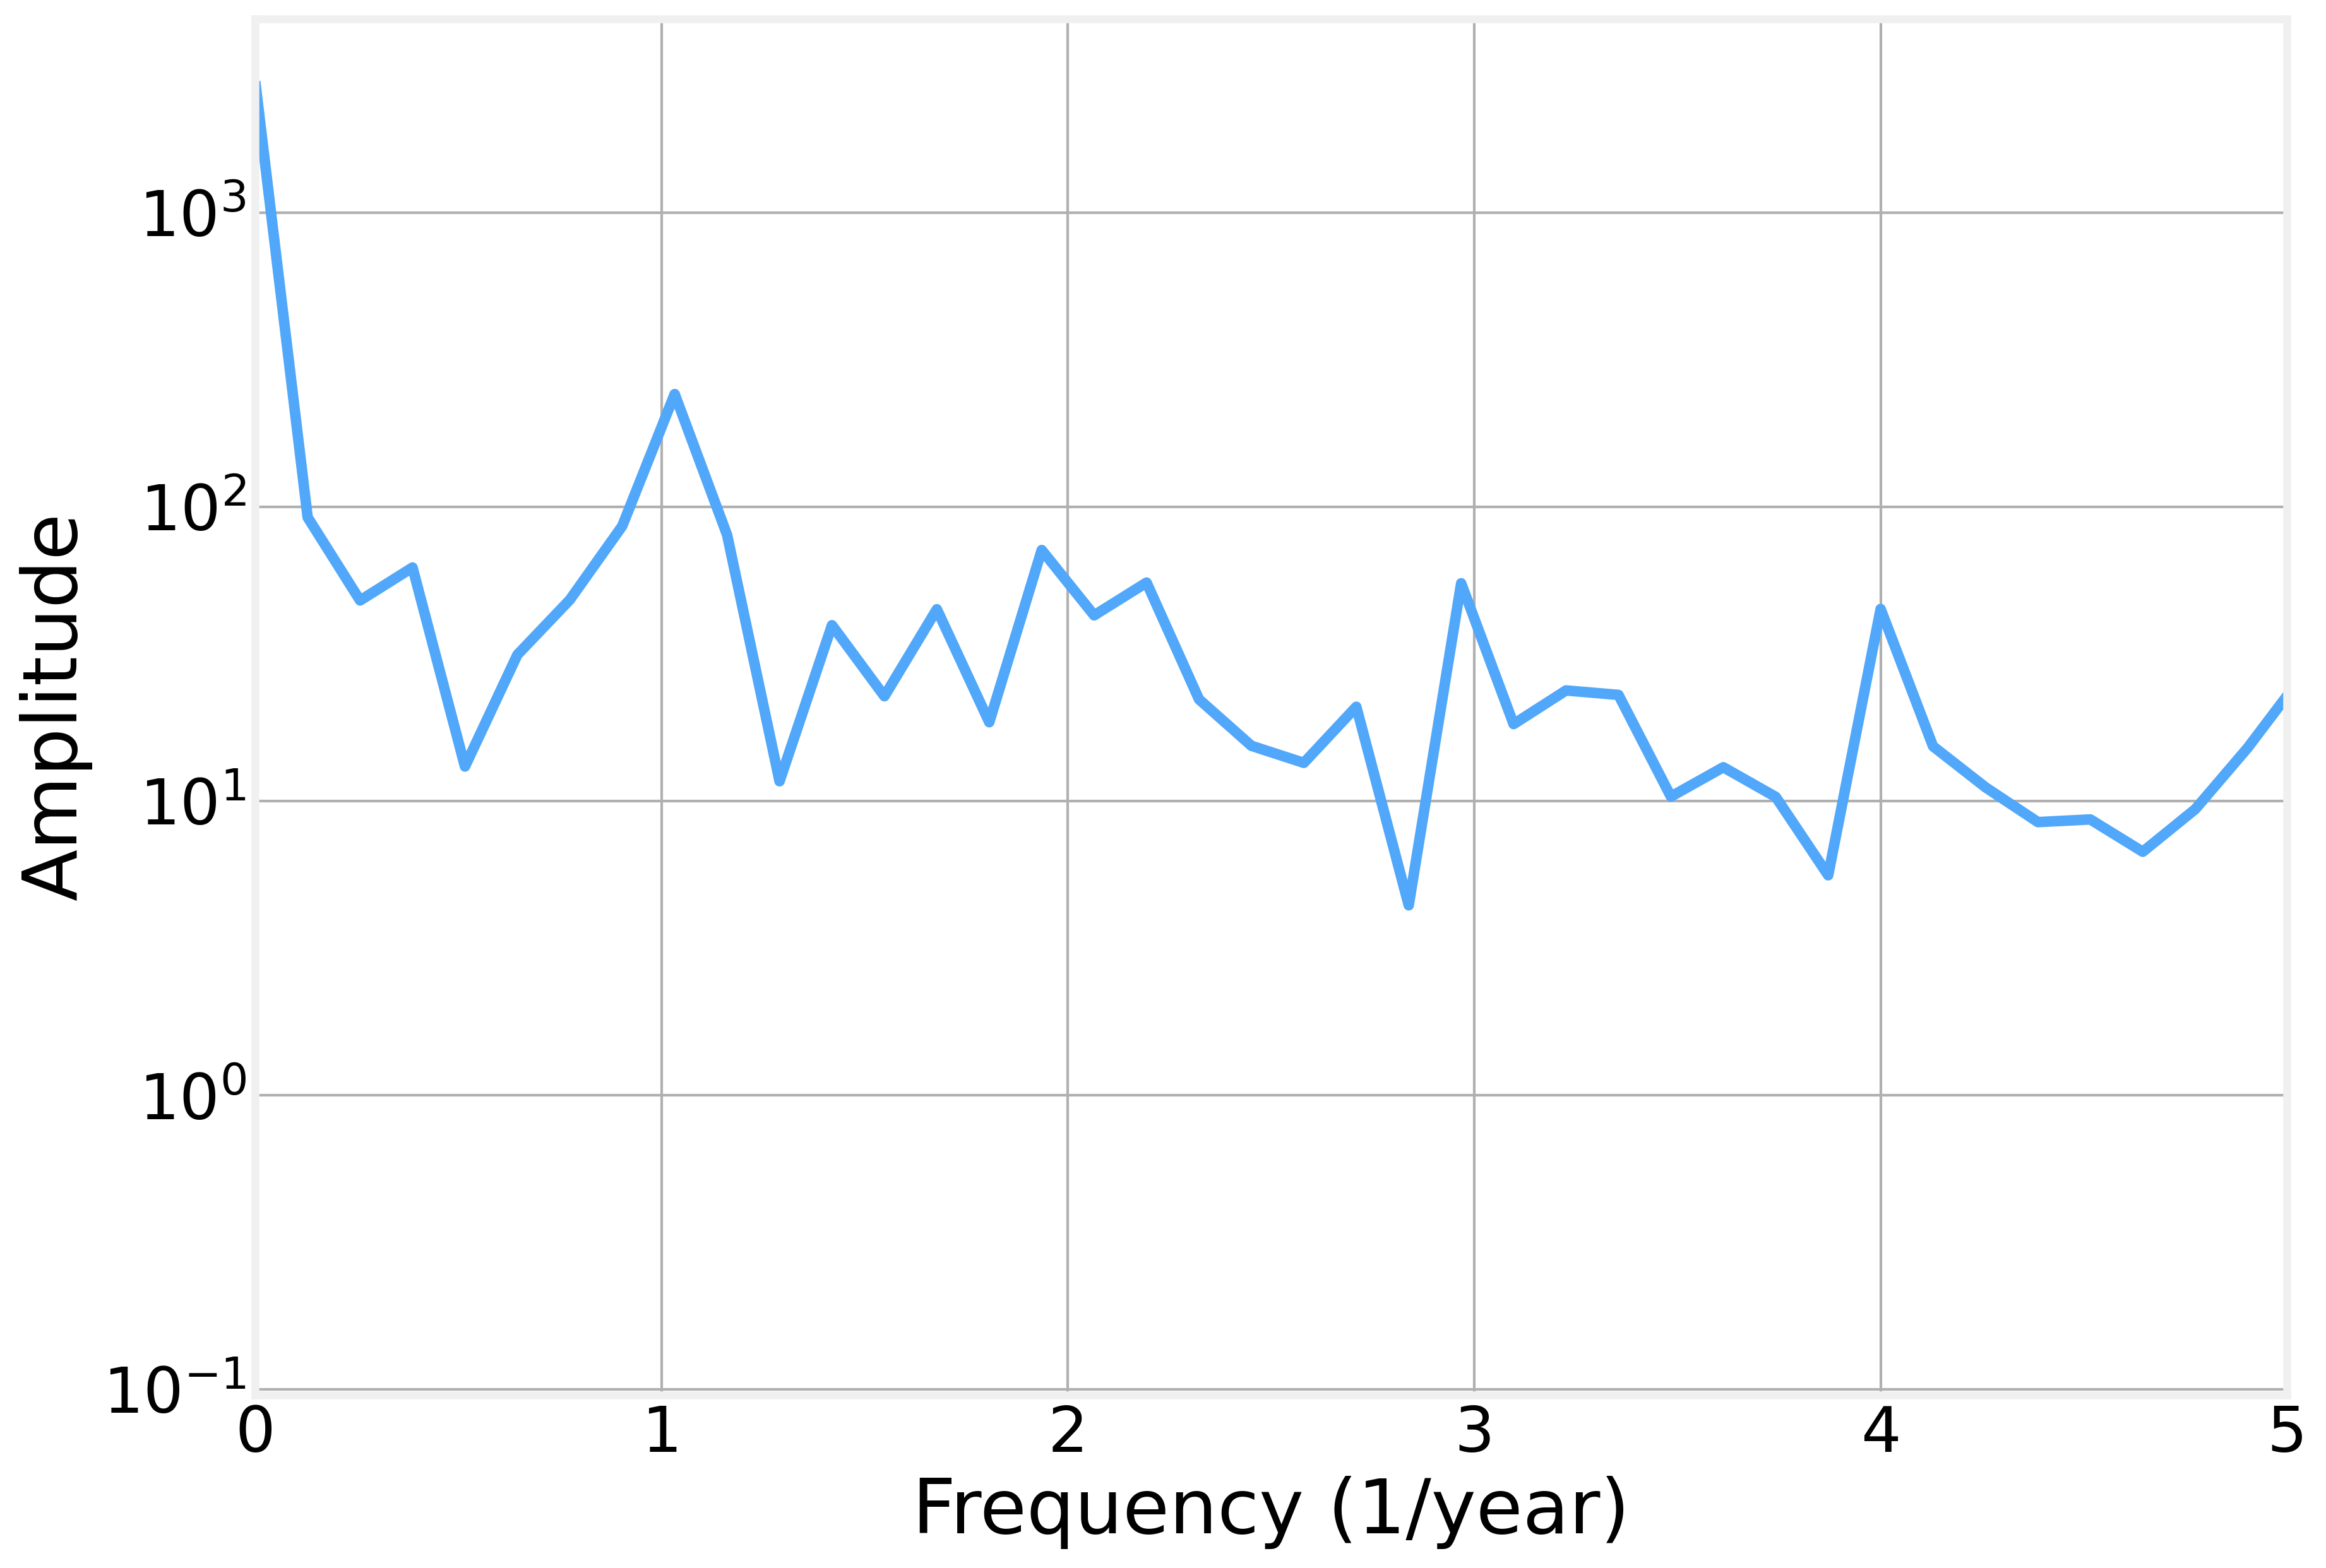

In [19]:
fig, ax = plt.subplots(1)
ax.semilogy(freq_values[:N//2], np.abs(fft_values[:N//2]))
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/year)')
ax.set_ylabel('Amplitude')

The frequency 0 component corresponds to a constant "level" after which the strongest component is ~1 year, indicating the yearly seasonality we had already identified. Higher freqencies have increasingly smaller Amplitudes indicating their decreasing importance.

We can remove some of the noise in the data by filtering out some of the higher frequencies. If we set every frequency higher than 2/year to zero

In [20]:
filtered = fft_values.copy()
filtered[np.abs(freq_values) > 2] = 0

And reconstrucing the original dataset using the filtered frequencies

In [21]:
signal_filtered = np.real(sp.fftpack.ifft(filtered))

We obtain a cleaner version of the signal

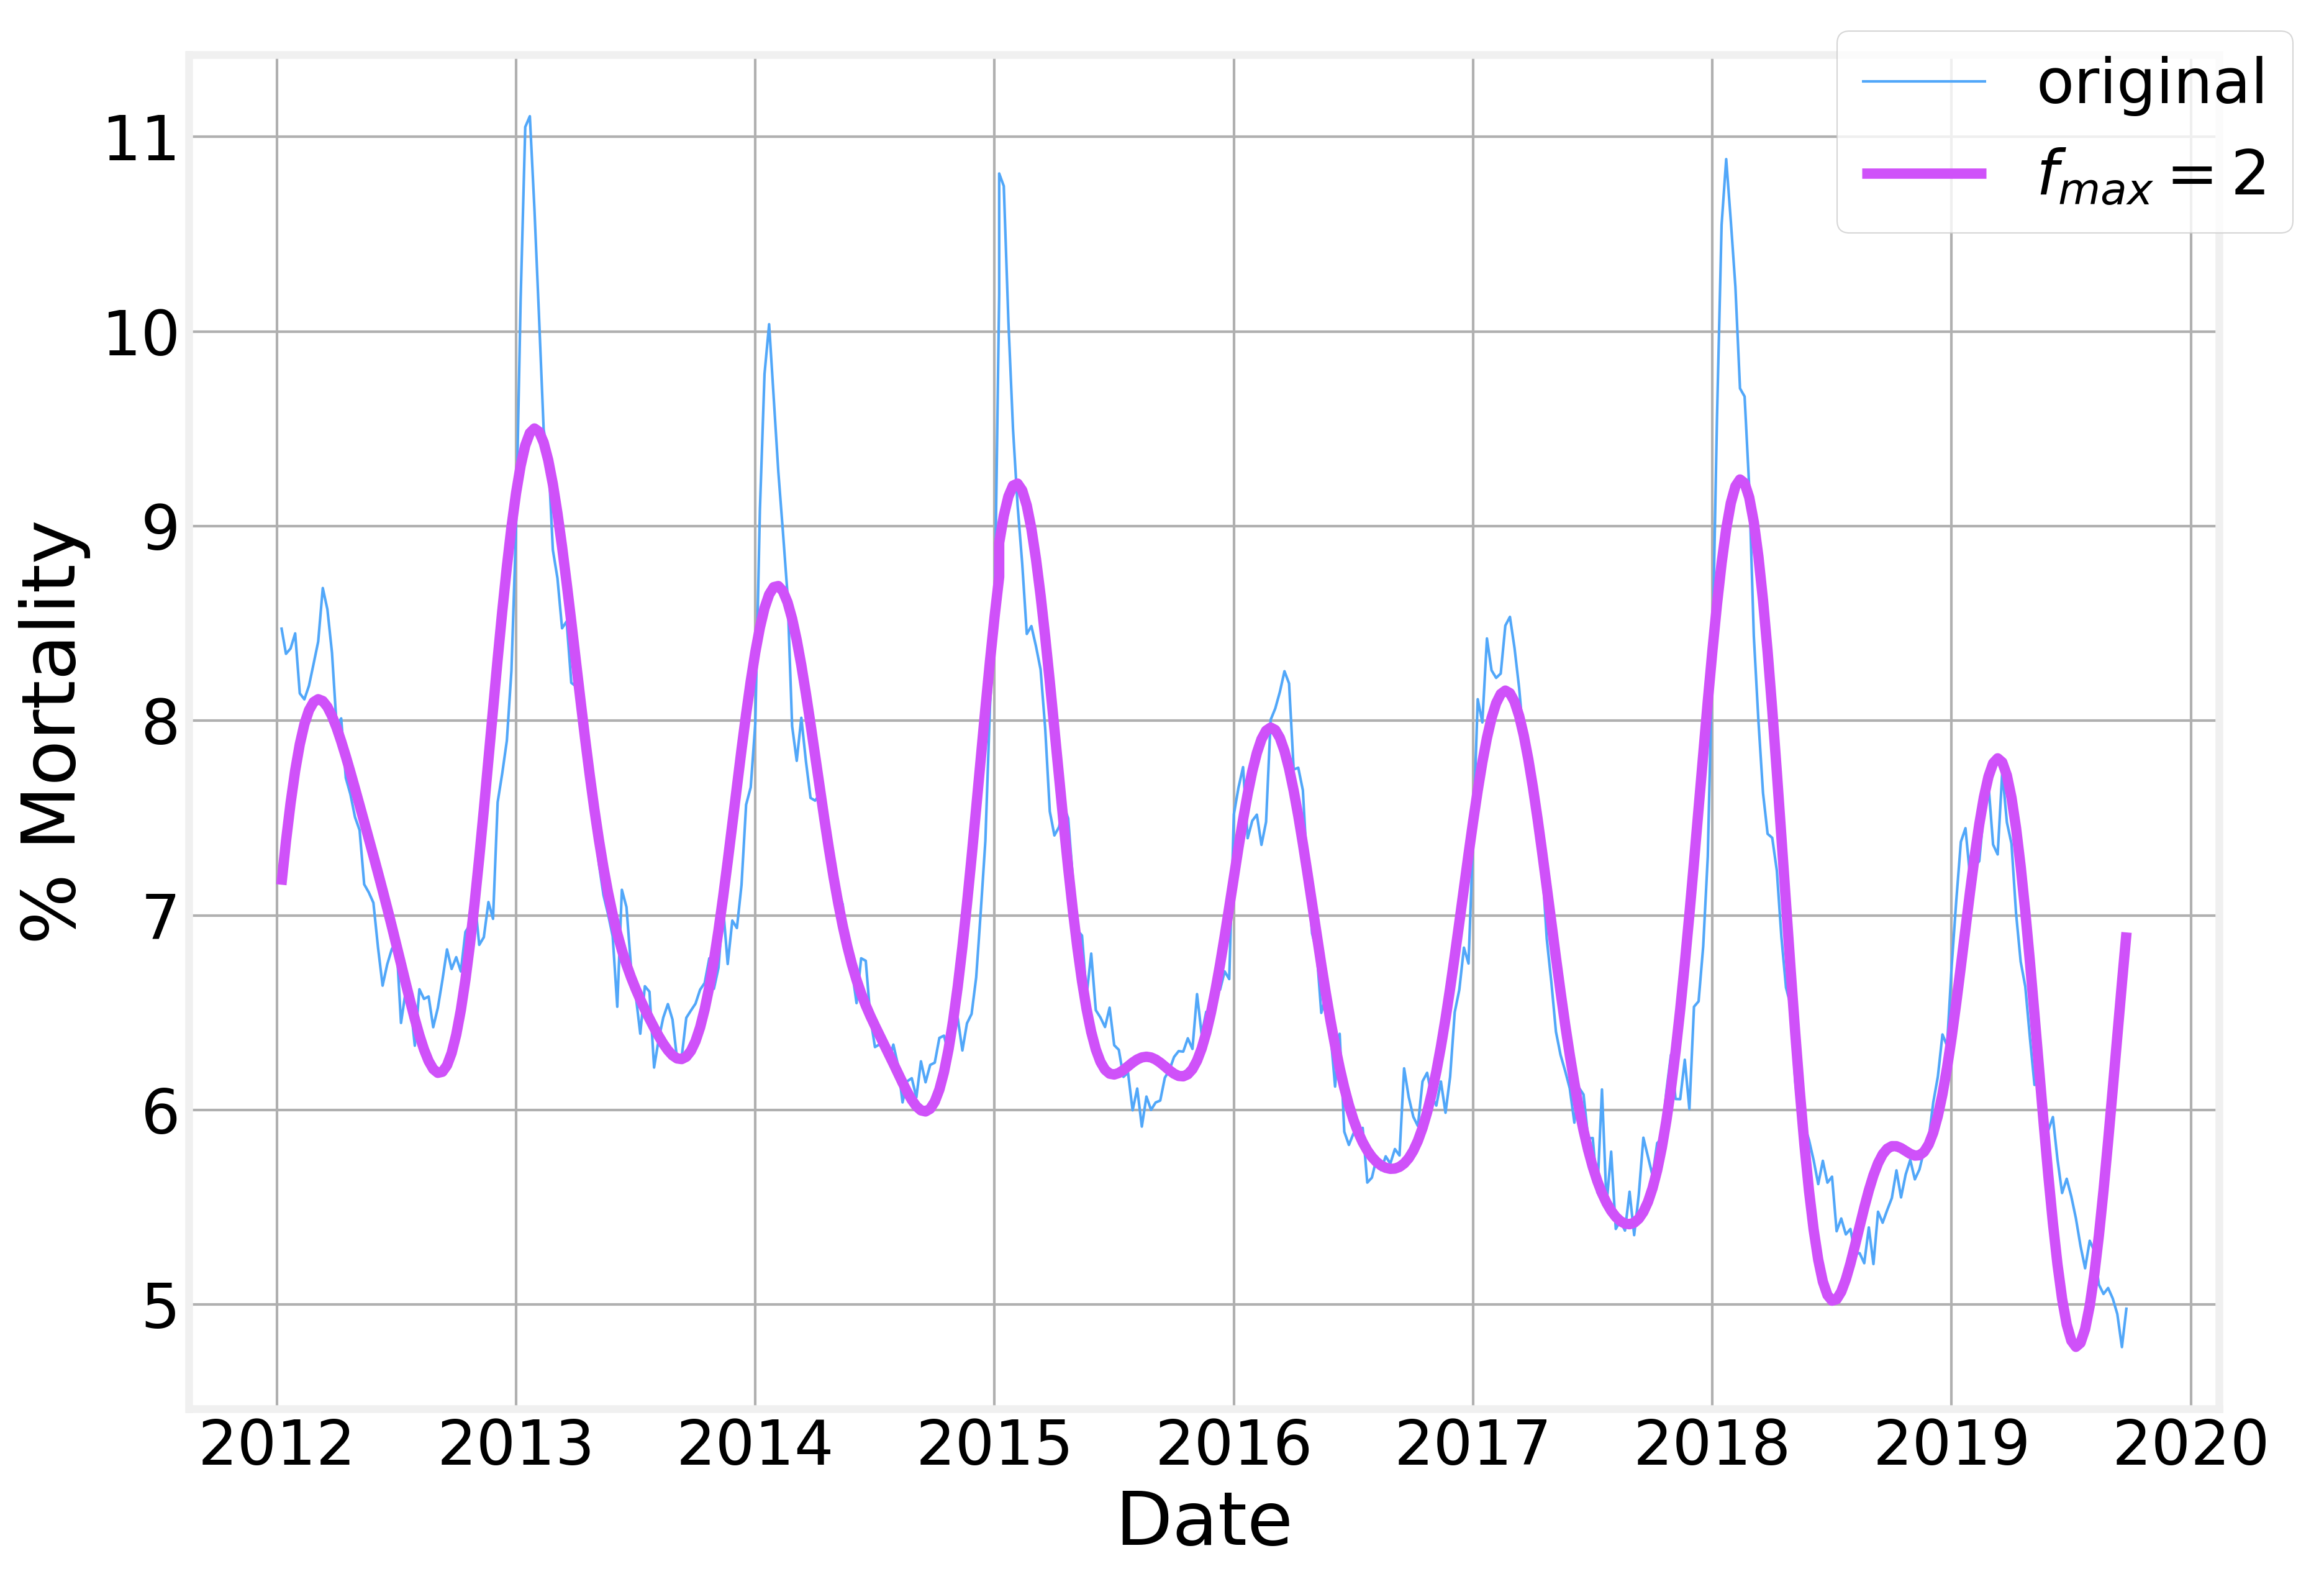

In [22]:
fig, ax = plt.subplots(1)
ax.plot(date, signal, lw=1, label='original')
ax.plot(date, signal_filtered, label=r'$f_{max}=2$')
ax.set_xlabel('Date')
ax.set_ylabel('% Mortality')
fig.legend()

Naturally, the more frequencies we include the closer we get to the original dataset

In [23]:
filtered2 = fft_values.copy()
filtered2[np.abs(freq_values) > 4] = 0
signal_filtered2 = np.real(sp.fftpack.ifft(filtered2))

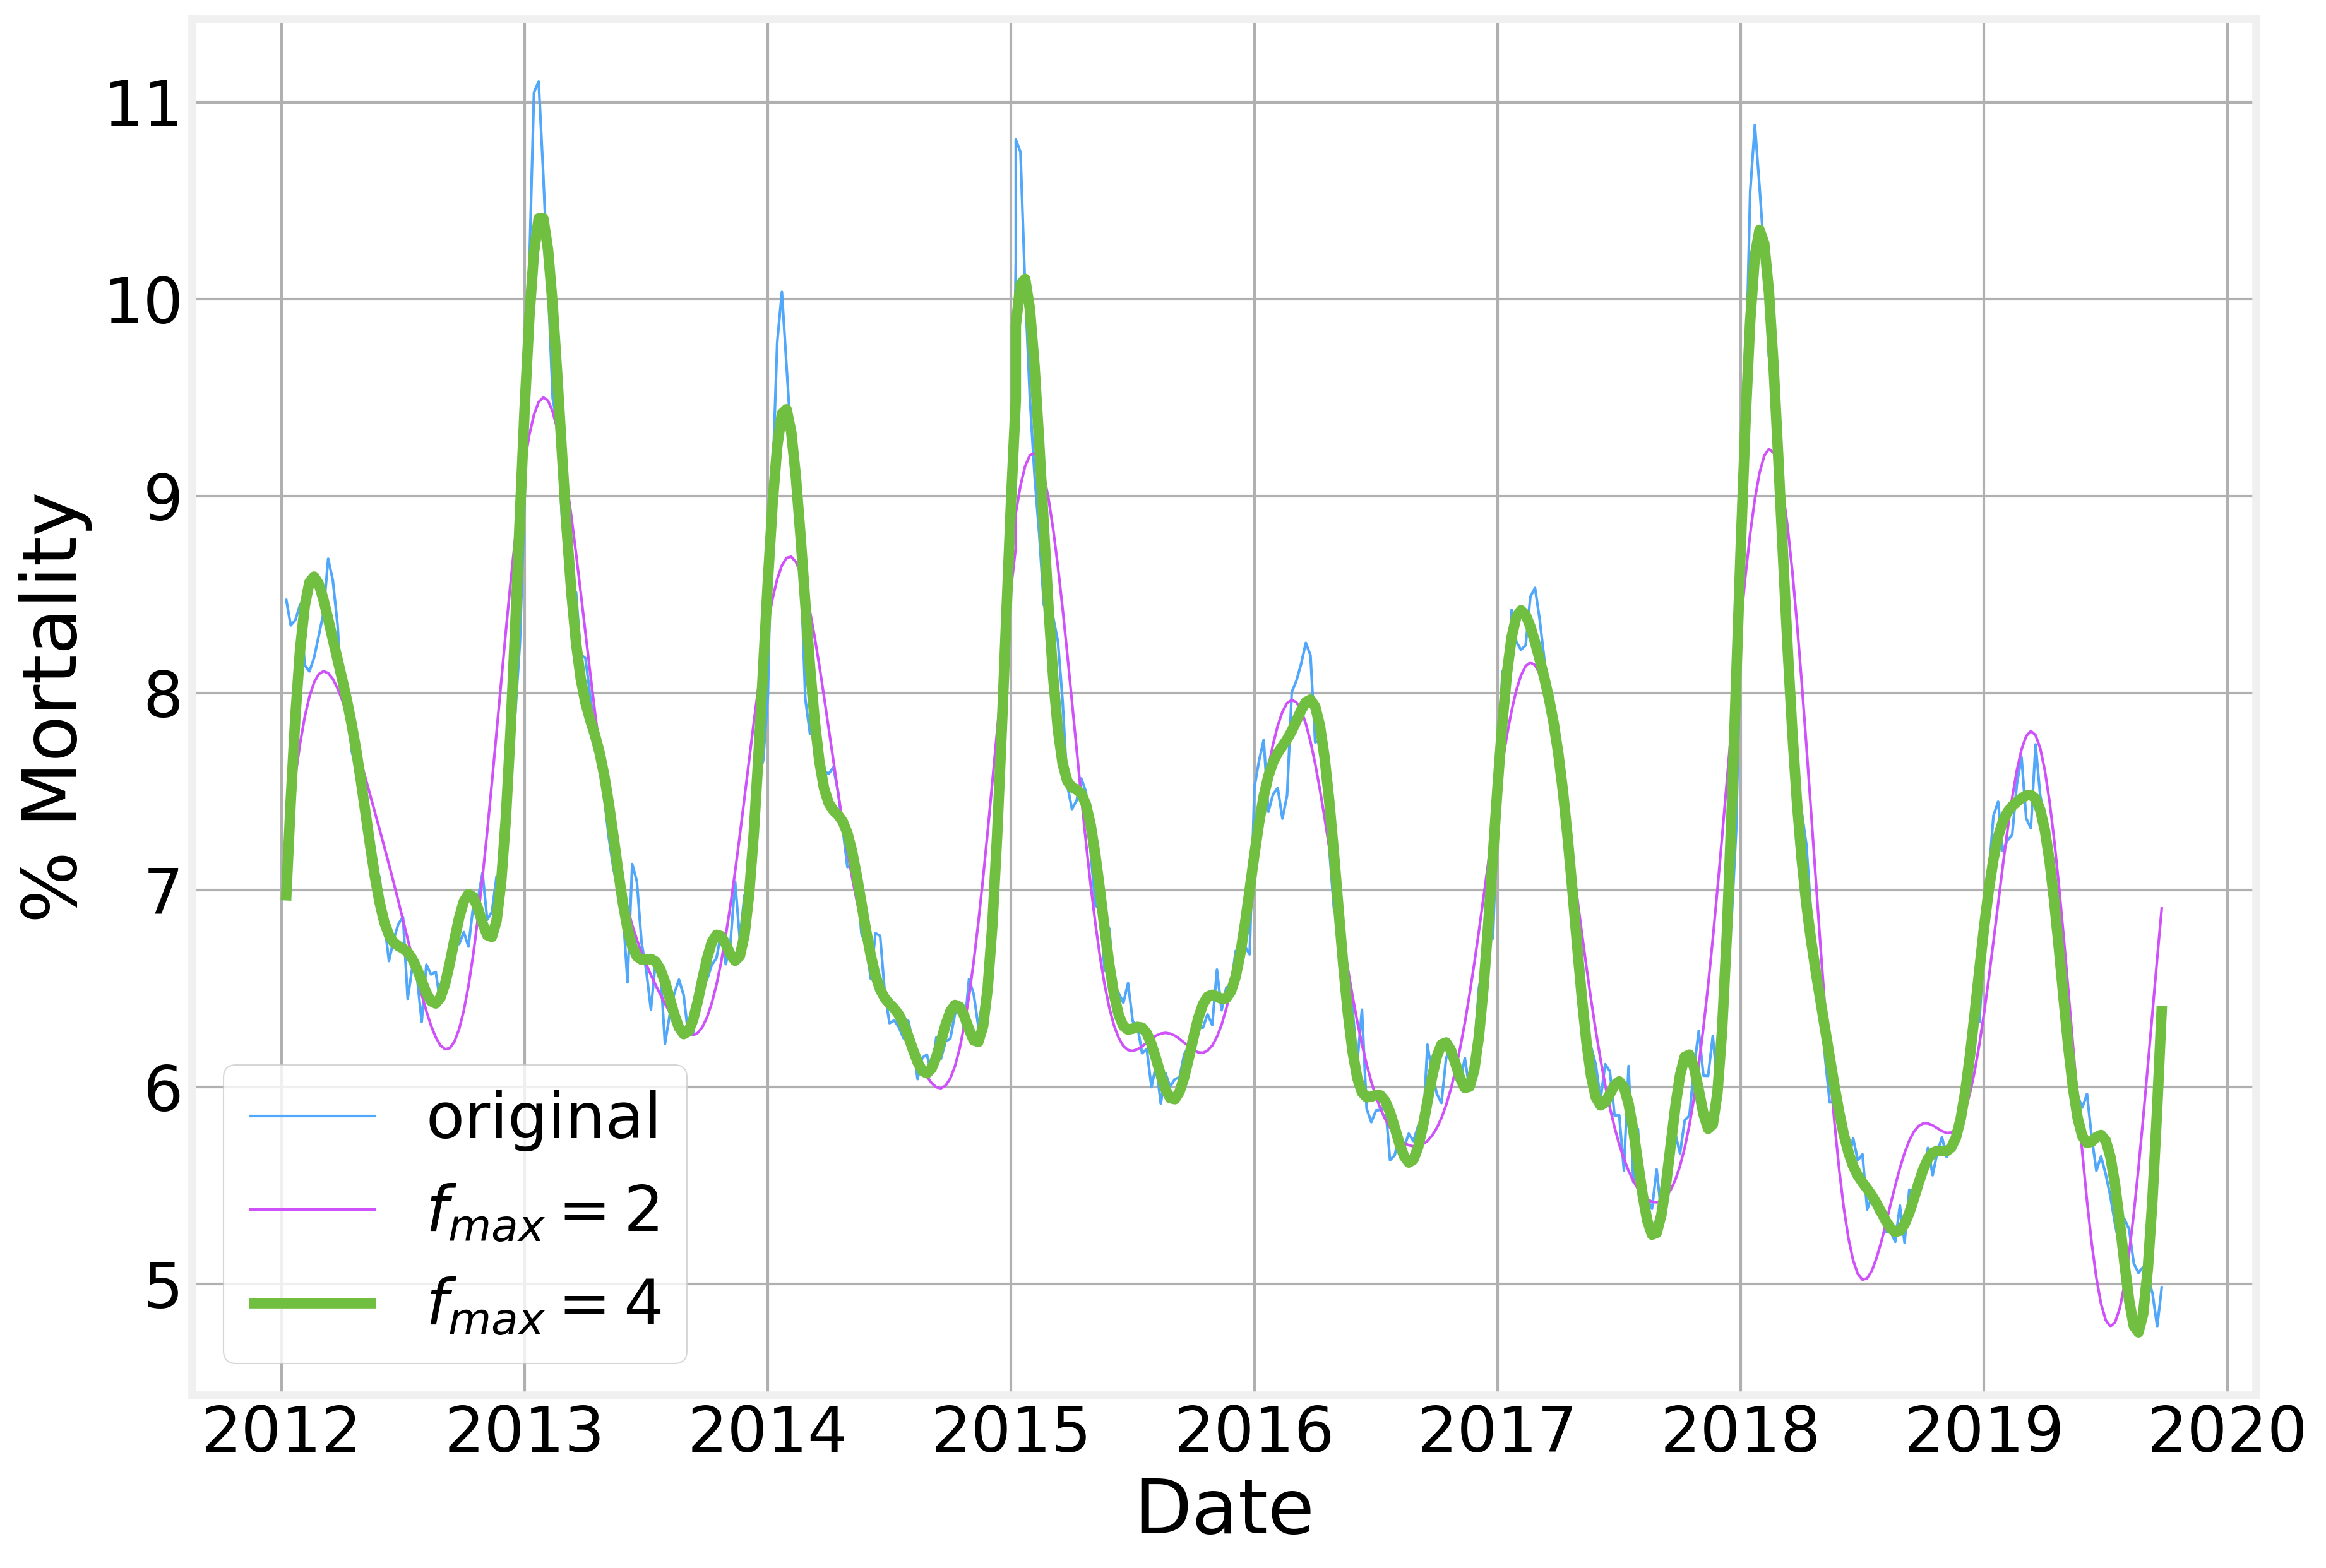

In [24]:
fig, ax = plt.subplots(1)
ax.plot(date, signal, lw=1, label='original')
ax.plot(date, signal_filtered, lw=1, label=r'$f_{max}=2$')
ax.plot(date, signal_filtered2, label=r'$f_{max}=4$')
ax.set_xlabel('Date')
ax.set_ylabel('% Mortality')
plt.legend()

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>